# Final Project. Communities and Crime

The objective of this project is to predict the _ViolentCrimesPerPop_ quantity which ilustrates the number of violent crimes per 100k population.

## Import all necessary packages

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv

from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

## Exploring and Cleaning Data

### Extract columns names from _communities.names_

In [2]:
with open("communities.names") as NamesFile:
    Lines = NamesFile.readlines()[75:203]
ColumnsNames = [Line.split()[1] for Line in Lines]

### Read data from _communities.data_

In [3]:
Data = pd.read_csv("communities.data", index_col=False, names=ColumnsNames)
# Check if DataFrame looks ok...
Data.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


For easier data manipulation, we will make a copy of the whole DataFrame without the _communityname_ column.

In [4]:
Data = Data.drop(["communityname"], axis=1)
Data

,state,county,community,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,1,0.19,0.33,0.02,0.90,0.12,0.17,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,1,0.00,0.16,0.12,0.74,0.45,0.07,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,1,0.00,0.42,0.49,0.56,0.17,0.04,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,1,0.04,0.77,1.00,0.08,0.12,0.10,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,1,0.01,0.55,0.02,0.95,0.09,0.05,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,10,0.01,0.40,0.10,0.87,0.12,0.16,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,10,0.05,0.96,0.46,0.28,0.83,0.32,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,10,0.16,0.37,0.25,0.69,0.04,0.25,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,10,0.08,0.51,0.06,0.87,0.22,0.10,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [5]:
# General info about the data
Data.info()
# Getting number of communities
n_communities = len(Data)
print(f"\nTotal of communities: {n_communities}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 127 entries, state to ViolentCrimesPerPop
dtypes: float64(100), int64(2), object(25)
memory usage: 1.9+ MB

Total of communities: 1994


### Dropping columns with deficient total data
Some columns might have half or more of the total data as non-defined, all these written as a "?", so we will drop the columns that might not help us for the analysis. Also, we will save information of the removed columns with the number of non-defined data.

In [6]:
with open("DeficientColumnsData.csv", "w") as DefData:
    HalfNumCommunities = n_communities//2
    for ColumnName in Data.columns:
        # Get number of "?" in given column and check if it is more or equal than the
        # total of communties
        Total_UnknownDataColumn = (Data[ColumnName] == "?").sum()
        if Total_UnknownDataColumn >= HalfNumCommunities:

            DefData.write(f"{ColumnName},{Total_UnknownDataColumn}\n")
            Data.drop(labels=[ColumnName], axis=1, inplace=True)

print(Data.info())
Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 103 entries, state to ViolentCrimesPerPop
dtypes: float64(100), int64(2), object(1)
memory usage: 1.6+ MB
None


,state,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,8,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,53,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,24,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,34,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,42,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,10,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,6,10,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,9,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,25,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


### Exploring isolated non-defined data
Now we will check if there is still columns with strings or non-numerical data in them.

In [7]:
Data.dtypes[Data.dtypes != "int64"][Data.dtypes != "float64"]

OtherPerCap    object
dtype: object

We can see that _OtherPerCap_ column has object dtype so let's observe the head column.

In [8]:
Data.OtherPerCap.head()

0    0.36
1    0.22
2    0.28
3    0.36
4    0.51
Name: OtherPerCap, dtype: object

It seems we have numerical data so let's search for any non-numerical data in it.

In [9]:
def CheckFloat(x):
    try:
        y = float(x)
        return True
    except ValueError:
        return False
    
Rows_NonNum_OtherPerCap = list( Data.OtherPerCap.index[Data.OtherPerCap.apply(CheckFloat) == False])
Data.loc[Rows_NonNum_OtherPerCap, "OtherPerCap"]

130    ?
Name: OtherPerCap, dtype: object

There is only data with a non-numeric value, so we decided to replace it with the mean value.

In [10]:
# Replacing OtherPerPop in index 130 with the mean of the available data
def GetMean_PrevOtherPerPop(Data):
    Sum = 0.0
    Values = Data.OtherPerCap.values
    for Val in Values:
        try:
            Sum += float(Val)
        except ValueError:
            pass
    return Sum/len(Values)

Data.loc[Rows_NonNum_OtherPerCap, "OtherPerCap"] = GetMean_PrevOtherPerPop(Data)
Data = Data.astype({"OtherPerCap":"float64"})
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 103 entries, state to ViolentCrimesPerPop
dtypes: float64(101), int64(2)
memory usage: 1.6 MB


And the final step for cleaning the dataset is dropping categorical data that won't contribute to the analysis as _state_ and _fold_ variables

In [11]:
Data.drop(["state", "fold"], axis=1, inplace=True)

## Transforming dataset to logaritmic scale

As final step, let's generate a DataFrame into logaritmic scale of the form
$$ \text{Log-Data} = \log_{10}{\left(1 + \frac{\text{Data} - \text{min(Data)}}{\text{max(Data)}-\text{min(Data)}}\right)}$$

In [12]:
LogData = dict()
for n, column in enumerate(Data.columns):
    MinData, MaxData = Data[column].min(), Data[column].max()
    LogData["log_" + column] = np.log10( 1.0  + (Data[column].to_numpy() - MinData)/(MaxData - MinData) )
 
LogData = pd.DataFrame(LogData)

print(LogData.info())
LogData

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 101 entries, log_population to log_ViolentCrimesPerPop
dtypes: float64(101)
memory usage: 1.5 MB
None


,log_population,log_householdsize,log_racepctblack,log_racePctWhite,log_racePctAsian,log_racePctHisp,log_agePct12t21,log_agePct12t29,log_agePct16t24,log_agePct65up,...,log_PctForeignBorn,log_PctBornSameState,log_PctSameHouse85,log_PctSameCity85,log_PctSameState85,log_LandArea,log_PopDens,log_PctUsePubTrans,log_LemasPctOfficDrugUn,log_ViolentCrimesPerPop
0,0.075547,0.123852,0.008600,0.278754,0.049218,0.068186,0.127105,0.167317,0.110590,0.120574,...,0.049218,0.152288,0.176091,0.178977,0.214844,0.049218,0.100371,0.079181,0.120574,0.079181
1,0.000000,0.064458,0.049218,0.240549,0.161368,0.029384,0.100371,0.201397,0.130334,0.103804,...,0.082785,0.176091,0.127105,0.204120,0.181844,0.008600,0.049218,0.161368,0.000000,0.222716
2,0.000000,0.152288,0.173186,0.193125,0.068186,0.017033,0.143015,0.167317,0.107210,0.120574,...,0.056905,0.173186,0.187521,0.222716,0.193125,0.004321,0.082785,0.008600,0.000000,0.155336
3,0.017033,0.247973,0.301030,0.033424,0.049218,0.041393,0.178977,0.176091,0.127105,0.082785,...,0.075547,0.113943,0.238046,0.214844,0.217484,0.008600,0.143015,0.107210,0.000000,0.049218
4,0.004321,0.190332,0.008600,0.290035,0.037426,0.021189,0.139879,0.139879,0.089905,0.133539,...,0.045323,0.235528,0.214844,0.206826,0.184691,0.017033,0.037426,0.008600,0.000000,0.012837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.004321,0.146128,0.041393,0.271842,0.049218,0.064458,0.155336,0.178977,0.130334,0.113943,...,0.086360,0.107210,0.127105,0.170262,0.143015,0.004321,0.107210,0.021189,0.000000,0.037426
1990,0.021189,0.292256,0.164353,0.107210,0.262451,0.120574,0.227887,0.269513,0.238046,0.056905,...,0.184691,0.096910,0.068186,0.041393,0.000000,0.008600,0.136721,0.079181,0.000000,0.161368
1991,0.064458,0.136721,0.096910,0.227887,0.017033,0.096910,0.130334,0.176091,0.117271,0.187521,...,0.096910,0.225309,0.206826,0.252853,0.245513,0.033424,0.120574,0.071882,0.281033,0.089905
1992,0.033424,0.178977,0.025306,0.271842,0.086360,0.041393,0.198657,0.240549,0.212188,0.149219,...,0.161368,0.214844,0.187521,0.201397,0.181844,0.012837,0.139879,0.123852,0.086360,0.075547


## Principal Components Analysis
The objective of applying this methodology is to identify and visualize the weights of multiple n-components of our dataset and catch the variables, or columns, more representative of the whole dataset

In [13]:
N_variables = len(LogData.columns)
PCA_Data = PCA(n_components=N_variables)
PCA_Data.fit(LogData)

PCA(n_components=101)

Then we can observe the percentages of variance by each componente given by PCA

<BarContainer object of 101 artists>

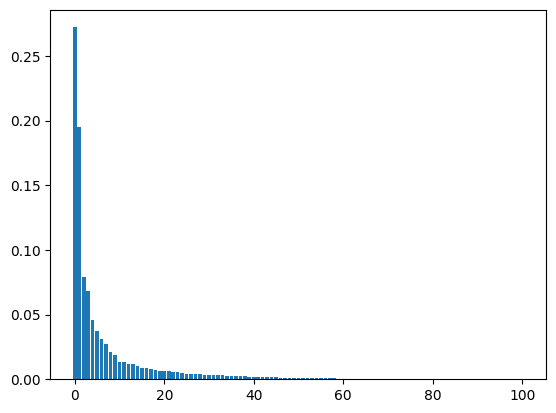

In [14]:
plt.bar(range(N_variables), PCA_Data.explained_variance_ratio_)

The next step is to select the variable in each eigenvector that has the maximum magnitude, this will be made by getting the index array of a sorted version of the components of all the eigenvectors

In [15]:
AbsCompsPCA = np.abs(PCA_Data.components_)
Index_SortEigenVecs = np.flipud(np.argsort(AbsCompsPCA, axis=0))
Index_SortEigenVecs

array([[ 98,  77,  53, ...,  13,  14,  26],
       [ 97,  51,  58, ...,  29,  15,  24],
       [  8,  74,   5, ...,  30,  16,  28],
       ...,
       [ 86,  54, 100, ...,  94,  95,  90],
       [ 51,  20,  97, ...,  95,  85,  94],
       [ 40, 100,  98, ...,  97,  49,  68]])

And for more insight of these components, let's calculate how many of these we need to considere to represent the 85%, 90% and 95% of the total variance of the dataset.

In [16]:
def Find_NumCompsByPercent(Percent):
    if isinstance(Percent, float):
        N = 1
        while True:
            SumVar = PCA_Data.explained_variance_ratio_[:N].sum()
            
            if SumVar >= Percent:
                return (N, SumVar)
            else:
                N += 1
    
    elif isinstance(Percent, list):
        Cant = len(Percent)
        List_N_Perc = Cant*[(0, 0.0)]
        
        for index in range(Cant):
            N = 1
            while True:
                SumVar = PCA_Data.explained_variance_ratio_[:N].sum()
            
                if SumVar >= Percent[index]:
                    List_N_Perc[index] = (N, SumVar)
                    break
                else:
                    N += 1

        return List_N_Perc

In [17]:
Percents = [0.85, 0.90, 0.95]
Num_SumVar = Find_NumCompsByPercent(Percents)
Num_SumVar

[(15, 0.8558452489465516), (21, 0.9007990050159856), (33, 0.9526571690610277)]

We got that with the first 15, 22 and 33 components we have an 85%, 90% and 95% of the variance respectively. So then, we will select only the maximum absolute weights of the first 15 or less non-repeated components; jumping from first to second maximum values if necessary

In [18]:
TotalVars = Num_SumVar[0][0]
Prior_VarComponents = set()
Level = 0

while len(Prior_VarComponents) != TotalVars:
    for n in range(TotalVars):
        if len(Prior_VarComponents) == TotalVars:
            continue
        
        VarIndex = Index_SortEigenVecs[Level, n]
        
        if VarIndex not in Prior_VarComponents:
            Prior_VarComponents.add( VarIndex )
    Level += 1

Prior_VarComponents = list(Prior_VarComponents)
Prior_VarComponents, len(Prior_VarComponents)

([97, 98, 35, 4, 37, 73, 77, 81, 51, 84, 53, 22, 23, 58, 91], 15)

Now let's generate a _FinalData_ DataFrame with these columns indexes and the percentage values for each race per community since the weren't included via PCA. The reason of adding these race percentages columns is to stablish a more complete demographic study by using social and economic variable and relate them with the rate of violent crimes.

In [19]:
FinalData = dict()
for index, column in enumerate(LogData.columns):
    if index in Prior_VarComponents:
        FinalData[column] = LogData.loc[:, column].to_numpy()

FinalData = pd.DataFrame(FinalData)
FinalData["log_racepctblack"] = LogData.log_racepctblack
FinalData["log_racePctWhite"] = LogData.log_racePctWhite
FinalData["log_racePctAsian"] = LogData.log_racePctAsian
FinalData["log_racePctHisp"] = LogData.log_racePctHisp
FinalData["log_ViolentCrimesPerPop"] = LogData.log_ViolentCrimesPerPop

print(FinalData.info())
FinalData

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   log_racePctAsian         1994 non-null   float64
 1   log_blackPerCap          1994 non-null   float64
 2   log_indianPerCap         1994 non-null   float64
 3   log_PctEmplProfServ      1994 non-null   float64
 4   log_PctOccupMgmtProf     1994 non-null   float64
 5   log_NumImmig             1994 non-null   float64
 6   log_PctImmigRec5         1994 non-null   float64
 7   log_PctRecImmig8         1994 non-null   float64
 8   log_PctHousOwnOcc        1994 non-null   float64
 9   log_PctHousNoPhone       1994 non-null   float64
 10  log_OwnOccHiQuart        1994 non-null   float64
 11  log_RentHighQ            1994 non-null   float64
 12  log_PctForeignBorn       1994 non-null   float64
 13  log_PopDens              1994 non-null   float64
 14  log_PctUsePubTrans      

,log_racePctAsian,log_blackPerCap,log_indianPerCap,log_PctEmplProfServ,log_PctOccupMgmtProf,log_NumImmig,log_PctImmigRec5,log_PctRecImmig8,log_PctHousOwnOcc,log_PctHousNoPhone,log_OwnOccHiQuart,log_RentHighQ,log_PctForeignBorn,log_PopDens,log_PctUsePubTrans,log_racepctblack,log_racePctWhite,log_racePctHisp,log_ViolentCrimesPerPop
0,0.049218,0.120574,0.103804,0.149219,0.181844,0.012837,0.103804,0.033424,0.181844,0.056905,0.071882,0.139879,0.049218,0.100371,0.079181,0.008600,0.278754,0.068186,0.079181
1,0.161368,0.123852,0.064458,0.060698,0.133539,0.004321,0.209515,0.096910,0.093422,0.064458,0.082785,0.146128,0.082785,0.049218,0.161368,0.049218,0.240549,0.029384,0.222716
2,0.068186,0.103804,0.029384,0.110590,0.120574,0.000000,0.025306,0.017033,0.149219,0.167317,0.064458,0.103804,0.056905,0.082785,0.008600,0.173186,0.193125,0.017033,0.155336
3,0.049218,0.143015,0.064458,0.161368,0.143015,0.008600,0.079181,0.045323,0.292256,0.045323,0.075547,0.247973,0.075547,0.143015,0.107210,0.301030,0.033424,0.041393,0.049218
4,0.037426,0.107210,0.000000,0.139879,0.164353,0.000000,0.029384,0.017033,0.271842,0.021189,0.113943,0.139879,0.045323,0.037426,0.008600,0.008600,0.290035,0.021189,0.012837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.049218,0.103804,0.000000,0.225309,0.230449,0.004321,0.149219,0.071882,0.190332,0.029384,0.103804,0.149219,0.086360,0.107210,0.021189,0.041393,0.271842,0.064458,0.037426
1990,0.262451,0.100371,0.071882,0.149219,0.093422,0.021189,0.209515,0.212188,0.086360,0.068186,0.133539,0.206826,0.184691,0.136721,0.079181,0.164353,0.107210,0.120574,0.161368
1991,0.017033,0.096910,0.075547,0.146128,0.120574,0.025306,0.068186,0.045323,0.136721,0.117271,0.110590,0.143015,0.096910,0.120574,0.071882,0.096910,0.227887,0.096910,0.089905
1992,0.086360,0.110590,0.079181,0.195900,0.170262,0.025306,0.164353,0.149219,0.123852,0.041393,0.167317,0.243038,0.161368,0.139879,0.123852,0.025306,0.271842,0.041393,0.075547


## Searching of outliers in data
For the final DataFrame, we will drop the _state_ and _fold_ columns since they are categorical data and drop outliers by using the Mahalanobis distance of the form:
$$D = \sqrt{(X-\mu)^{'}S^{-1}(X-\mu)}$$

Where $X$ are the data points, $\mu$ es the mean vector and $S$ is the covariance matrix of the whole dataset

In [20]:
# Getting mean vector and covariance matrix
MeanVec = FinalData.mean(axis=0)
InvCovMatrix = inv(FinalData.cov(ddof=0).to_numpy())

# Computing Mahalanobis distance
NumRows = len(FinalData.index)
DataColumns = FinalData.columns

MahaDistance = np.zeros(NumRows)
for row in range(NumRows):
    MahaDistance[row] = mahalanobis(FinalData.loc[row, DataColumns].to_numpy(), MeanVec, InvCovMatrix)

MinMahaDistance, MaxMahaDistance = MahaDistance.min(), MahaDistance.max()
print(f"{MinMahaDistance=}, {MaxMahaDistance=}")

MinMahaDistance=1.5990989300189957, MaxMahaDistance=12.10539998631642


The method to identify the outliers, by using the Mahalanobis distances, is using a specific p-value for a chi-square distribution of 19 degrees of freedom (this number is used since it's the number of variables/columns in the dataset).

For p-values of 0.05, 0.15, 0.25 and 0.50, we have signficance levels of 30.14, 25.33, 22.72 and 18.34, respectively. By comparing the minimum and maximum Mahalanobis distances gotten in the previous cell with each significance level; we can conclude that there are no outliers in this dataset with the present method.

With no other step to apply on the dataset, we will save this DataFrame as _Log_FinalData.csv_

In [21]:
FinalData.to_csv("Log_FinalData.csv")

## Exploratory Data Analysis

### Correlation matrix of all columns

<AxesSubplot: >

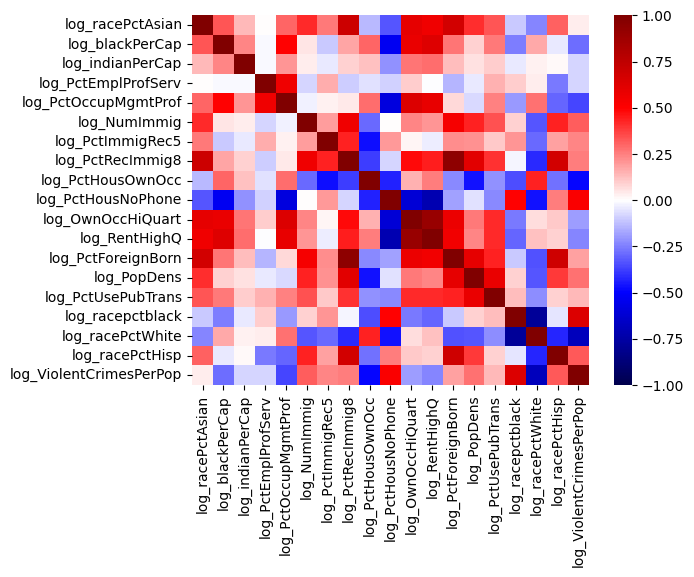

In [22]:
CorrMap = FinalData.corr()

sns.heatmap(CorrMap, vmin=-1, vmax=1, cmap="seismic", annot=False)